In [2]:
import os
print(os.getcwd())
try:
    os.chdir('DDE')
except:
    print('you are already in DDE')


import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch import nn 
import copy

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold
torch.manual_seed(2)    # reproducible torch:2 np:3
np.random.seed(3)

from dde_config import dde_NN_config
from dde_torch import dde_NN_Large_Predictor
from stream_dde import supData, unsupData, smiles2index, smiles2vector

c:\Users\parke\Documents\GitHub\CASTER\DDE
you are already in DDE


In [3]:
sample_smiles = ['Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1','COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1']

vector = smiles2vector(sample_smiles[0],sample_smiles[1]) # pass this function 
vector.shape


(1722,)

In [4]:
vals = vector[vector >0]
vals

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [5]:
i1, i2 = smiles2index(sample_smiles[0],sample_smiles[1])
print(i1) # I think these are the indexes of the vector to switch to on
print(i2)


[623, 282, 28, 196, 180, 317, 25, 154, 29]
[101, 282, 69, 196, 921, 324, 973, 447, 205, 89, 105, 25, 651, 127]


In [6]:
# These are in stream_dde.py 
import numpy as np
import pandas as pd
import torch
from torch.utils import data

from subword_nmt.apply_bpe import BPE
import codecs # in the standard python library
dataFolder = './data'

vocab_path = dataFolder + '/codes.txt' # this is a predefined set of common pseduo functional groups defined as common patterns
bpe_codes_fin = codecs.open(vocab_path)
bpe = BPE(bpe_codes_fin, merges=-1, separator='')

vocab_map = pd.read_csv(dataFolder + '/subword_units_map.csv')
idx2word = vocab_map['index'].values
words2idx = dict(zip(idx2word, range(0, len(idx2word)))) # I think this creates a dictionary 
max_set = 30

In [7]:
words2idx['#'] # dictionary of pseudo funcitonal groups


1

In [8]:
t1 = bpe.process_line(sample_smiles[0]).split() # this line takes a smile string and breaks into functional groups
print(sample_smiles[0])
t1

Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1


['Cl', 'c1ccccc1', '-', 'c1n', 'c(-', 'c2ccccc2)', 'n', '[nH]', '1']

In [9]:
bpe_codes_fin.read() # this 

''

In [10]:
import numpy as np
def get_func_groups(smile, bpe) -> list:
   return bpe.process_line(smile).split()

def func_groups_to_vector(func_list, functional_group_index_dict)-> np.array:
   indexes =  [functional_group_index_dict[group] for group in func_list] 
   vector_of_smile =v1 = np.zeros(len(functional_group_index_dict),) # initalize as zeros.
   vector_of_smile[indexes] = 1 # assign all the index of pseudo functional groups present in smile to be 1.
   return vector_of_smile

def smile_to_vector(smile, bpe, functional_group_index_dict) ->np.array:
   """
      You should make your own dictionaries for bpe and for functional group index for your own dataset. I don't know what would be best for that
   """
   functional_groups = get_func_groups(smile, bpe)
   vector = func_groups_to_vector(functional_groups, functional_group_index_dict)
   return vector


In [11]:
import pandas as pd
from tdc.single_pred import ADME
data = ADME(name = 'CYP2C9_Veith')  # this is the binary classification problem
split = data.get_split()

Found local copy...
Loading...
Done!


In [12]:
df = split['train'][['Drug', 'Y']]


# this is inefficent but that does not matter now just proof of concept

drugs = df['Drug']
vectors = []

for drug in drugs:
    vec = smile_to_vector(drug,bpe, words2idx)
    vectors.append(vec)


# Create a dummy model

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=5, random_state=42, n_estimators =1000)
Training_size =7000
X = pd.DataFrame(np.array(vectors))
y = df['Y']
model.fit(X.iloc[:Training_size],y.iloc[:Training_size])
score = model.score(X.iloc[Training_size:], y.iloc[Training_size:])
print(f'A simple Random Forest had an accuray rate of { round(score ,2)*100}%')

A simple Random Forest had an accuray rate of 56.00000000000001%


In [14]:
preds = model.predict(X.iloc[Training_size:])
print(f'There where {sum(preds)} 1s predicted. This is because the training data is unbalenced.')

There where 0 1s predicted. This is because the training data is unbalenced.


In [15]:
X

,0,1,2,3,4,5,6,7,8,9,...,1712,1713,1714,1715,1716,1717,1718,1719,1720,1721
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print(f'there are {sum(y)} 1 targets and {len(y) -sum(y)} 0 targets')

there are 2813 1 targets and 5652 0 targets


The dummy predicts that everything is a 0 becasue 3/4 of targets are 0s.
To address this I am going to balence the dataset

# Dummy Regressor after balancing  

In [17]:
train_df = X
num_functional_groups = (train_df == 1).astype(int).sum(axis=1) # this just counts the 1s in each row.
train_df['num_functional_groups'] = num_functional_groups

In [18]:
print(y.value_counts())
print(train_df['num_functional_groups'].value_counts())

0    5652
1    2813
Name: Y, dtype: int64
11    1007
10     974
9      914
12     907
13     732
8      669
14     548
7      543
15     415
6      372
16     284
5      235
17     191
4      136
18     133
19      94
3       64
20      58
21      49
22      30
23      27
24      24
2       15
25      12
26      10
29       5
28       4
27       3
34       3
30       3
36       1
37       1
38       1
31       1
Name: num_functional_groups, dtype: int64


Text(0, 0.5, 'Count')

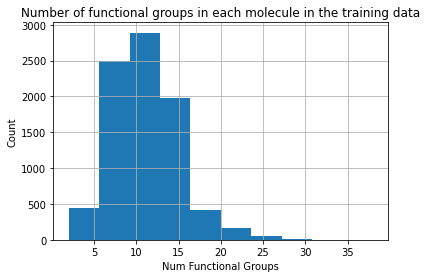

In [19]:
train_df['num_functional_groups'].hist()
plt.title('Number of functional groups in each molecule in the training data')
plt.xlabel('Num Functional Groups')
plt.ylabel('Count')

# Balance with Random Oversampling. 

1. This naive method just randomly resamples each category to be the same size. Because there are fewer 1s than 0s this method increases the size of the training data to add more examples of vectors with 1s.


In [38]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
X_resampled = pd.DataFrame(X_resampled)
y_resampled.value_counts()



0    5652
1    5652
Name: Y, dtype: int64

### Dummy Model with random over sampling

In [52]:
oversample_df = X_resampled
oversample_df['target'] =y_resampled
oversample_df = oversample_df.sample(frac=1).reset_index(drop=True) # shuffle the rows

oversample_df.head()


,0,1,2,3,4,5,6,7,8,9,...,1714,1715,1716,1717,1718,1719,1720,1721,num_functional_groups,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,0


In [45]:
over_sample_model = RandomForestClassifier(max_depth=5, random_state=42, n_estimators =1000, max_samples=100)
training_size = 10000
over_sample_model.fit(X_resampled.iloc[:training_size], y_resampled[:training_size])
score = over_sample_model.score(X_resampled.iloc[training_size:], y_resampled[training_size:])
print(f'The accuracy of the Random Forest with random oversampling is {score}')

The accuracy of the Random Forest with random oversampling is 0.7607361963190185


In [46]:
preds = over_sample_model.predict(X_resampled.iloc[:training_size])
print(preds.shape)
pd.Series(preds).value_counts()

(10000,)


0    6737
1    3263
dtype: int64

# Conclusion of dummy model testing

1. The data is not ballenced.%
2. The base line random forest with 1 hot encoding and a num_functional_groups column had an accuray rate on a subset of the training data of 74%